# Preambule

In [1]:
library(tidyverse)
library(stringr)
library("ggpubr")
library(igraph)
library(ggraph)
library("inTrees")
library(ranger)
library(parallel)
library(caret)
library(endoR)
library(data.table)
library(clustermq)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectru

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] clustermq_0.8.95.1 data.table_1.13.4  endoR_0.1.0        caret_6.0-86      
 [5] lattice_0.20-41    ranger_0.12.1      inTrees_1.3        ggraph_2.0.4      
 [9] igraph_1.2.6       ggpubr_0.4.0       forcats_0.5.0      stringr_1.4.0     
[13] dplyr_1.0

# Data

In [3]:
titanic %>% summary

    gender          age                       class            embarked   
 female: 489   Min.   : 0.1667   1st             :324   Belfast    : 197  
 male  :1718   1st Qu.:22.0000   2nd             :284   Cherbourg  : 271  
               Median :29.0000   3rd             :709   Queenstown : 123  
               Mean   :30.4363   deck crew       : 66   Southampton:1616  
               3rd Qu.:38.0000   engineering crew:324                     
               Max.   :74.0000   restaurant staff: 69                     
                                 victualling crew:431                     
          country          fare             sibsp            parch       
 England      :1125   Min.   :  0.000   Min.   :0.0000   Min.   :0.0000  
 United States: 264   1st Qu.:  0.000   1st Qu.:0.0000   1st Qu.:0.0000  
 Ireland      : 137   Median :  7.151   Median :0.0000   Median :0.0000  
 Sweden       : 105   Mean   : 19.992   Mean   :0.2959   Mean   :0.2284  
 X            :  81   3rd Qu.:

# RF

In [5]:
summary(titanic$survived)
n_yes <- sum(titanic$survived == 'yes')
n_samp <- length(titanic$survived)
samp_weight <- round(ifelse(titanic$survived == 'yes', 1-n_yes/n_samp, n_yes/n_samp), digits = 2)
summary(as.factor(samp_weight))

no  yes 
1496  711

0.32 0.68 
1496  711

In [6]:
set.seed(1313)
titanic_rf <- ranger(x = titanic %>% select(-survived), y = titanic$survived
                     , case.weights = samp_weight)
titanic_rf

Ranger result

Call:
 ranger(x = titanic %>% select(-survived), y = titanic$survived,      case.weights = samp_weight) 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      2207 
Number of independent variables:  8 
Mtry:                             2 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             19.30 % 

In [7]:
titanic_rf$confusion.matrix

     predicted
true    no  yes
  no  1320  176
  yes  250  461

# Bootstrap on cluster

## run

In [8]:
preclu <- preCluster(model = titanic_rf, model_type = 'ranger'
                     , data = titanic %>% select(-survived)
                     , target = titanic$survived, classPos = 'yes'
                     , times = 10 # number of bootstraps
                     , sample_weight = samp_weight # sample weight for resampling
                     , discretize = TRUE, K = 3
                     , in_parallel = TRUE, n_cores = 5)

Extract rules...

Discretise data

Discretise rules



In [9]:
# HPC parameters for clustermq
options(clustermq.scheduler = "sge", clustermq.template = "~/.clustermq.tmpl")
n_cores <- 5
tmpl <- list(conda = "/ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml"
             , cores = n_cores, job_time = '02:00:00', job_mem = '0.8G')

In [10]:
rules <- Q(model2DE_cluster
  , partition = preclu$partitions
  , export=list(data = preclu$data
                , target = titanic$survived
                , exec = preclu$exec
                , classPos = 'yes'
                , prune = TRUE, maxDecay = 0.05, typeDecay = 2 
                , filter = FALSE
                , in_parallel = TRUE, n_cores = n_cores
               )
  , n_jobs= length(preclu$partitions)
  , pkgs=c('data.table', 'parallel', 'caret', 'stringr', 'scales', 'dplyr', 'inTrees', 'endoR')
  , log_worker=FALSE
  , template = tmpl
 )

Warning message in (function (...) :
“Common data is 51.2 Mb. Recommended limit is  (set by clustermq.data.warning option)”
Submitting 10 worker jobs (ID: cmq6058) ...

Running 10 calculations (10 objs/51.2 Mb common; 1 calls/chunk) ...


[---------------------------------------------------]   0% (1/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (2/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (3/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (4/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (5/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (6/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (7/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (8/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (9/10 wrk) eta:  ?s

[----------------------------------------

## stability selection

In [36]:
# let's have a look at the effect of alpha
alphas <- evaluateAlpha(rules = rules, alphas = c(1:5, 7, 10), data = preclu$data)

17.69746  rules per sub-sample selected. 11 decisions in >= 7 subsets.
25.02798  rules per sub-sample selected. 15 decisions in >= 7 subsets.
30.6529  rules per sub-sample selected. 16 decisions in >= 7 subsets.
35.39491  rules per sub-sample selected. 20 decisions in >= 7 subsets.
39.57272  rules per sub-sample selected. 22 decisions in >= 7 subsets.
46.82307  rules per sub-sample selected. 27 decisions in >= 7 subsets.
55.96427  rules per sub-sample selected. 32 decisions in >= 7 subsets.


In [37]:
# with alpha = 1, we can already predict all samples! 
# with alpha = 3, we get 5 more decisions... let's go for alpha = 3
alphas$summary_table

alpha,n_dec,n_samp
<dbl>,<dbl>,<dbl>
1,11,2207
2,15,2207
3,16,2207
4,20,2207
5,22,2207
7,27,2207
10,32,2207


In [38]:
de_final <- stabilitySelection(rules = rules, alpha_error = 3)

30.6529  rules per sub-sample selected. 16 decisions in >= 7 subsets.


In [39]:
de_final$rules_summary %>% subset(inN >= 7) %>% presentRules(colN = colnames(preclu$data)) %>% head

condition,inN,len,support,err,pred,imp,imp_sd,n,n_sd
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gender__female>0.5,10,1,0.29655485,0.33155840,0.8605229,0.09817438,0.010103291,30.805608,4.881146
gender__female>0.5 & class__1st>0.5,10,2,0.10271985,0.08655914,0.9807829,0.08463343,0.010374807,7.643608,1.833917
gender__female>0.5 & embarked__Cherbourg>0.5,10,2,0.08195830,0.15295555,0.9580261,0.05702344,0.012970279,11.661249,2.426231
gender__female>0.5 & class__2nd>0.5,10,2,0.07343608,0.19175941,0.9431194,0.04540994,0.011357058,28.456902,4.481999
class__1st>0.5,10,1,0.18495014,0.40187218,0.7883795,0.03498455,0.005996503,19.150989,2.200002
gender__male>0.5,10,1,0.70344515,0.47815271,0.3560371,0.03251762,0.002800607,23.804735,10.204120


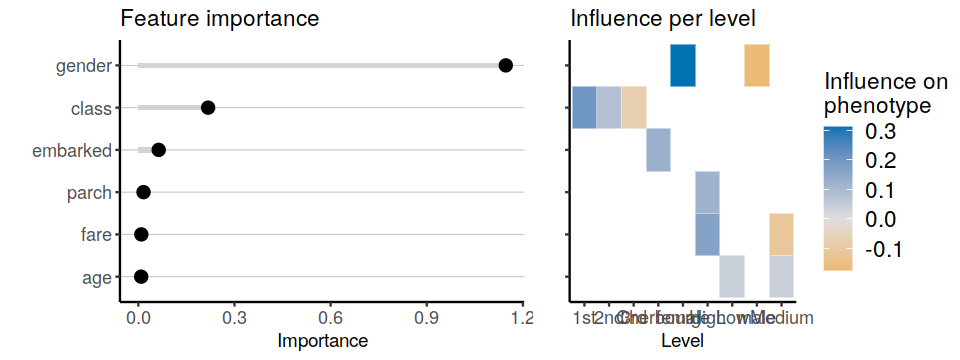

In [41]:
options(repr.plot.width=8, repr.plot.height=3)
plotFeatures(decision_ensemble = de_final)

In [46]:
# this is ugly.. we would like the influence plot to be largerthan the importance one
p_feat <- plotFeatures(decision_ensemble = de_final, return_all = TRUE
                       , levels_order = c('male', 'female', '3rd', '2nd', '1st', 'Cherbourg','Low', 'Medium', 'High')
                      )
names(p_feat)

[1] "importance"   "importance_p" "influences"   "influence_p"

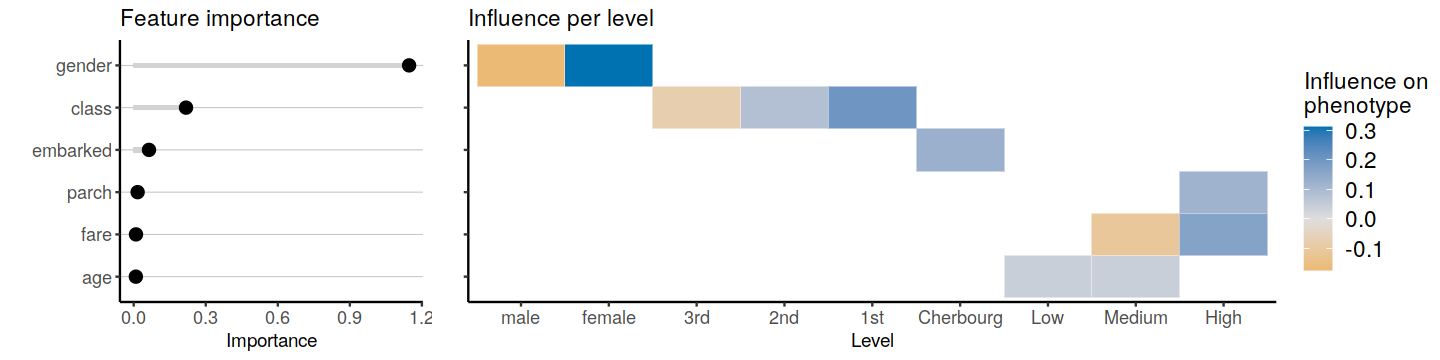

In [47]:
# women and children first? yes but especially if they are wealthy.. 
options(repr.plot.width=12, repr.plot.height=3)
ggarrange(p_feat$importance_p, p_feat$influence_p 
          , widths = c(0.3, 0.7)) # better! 

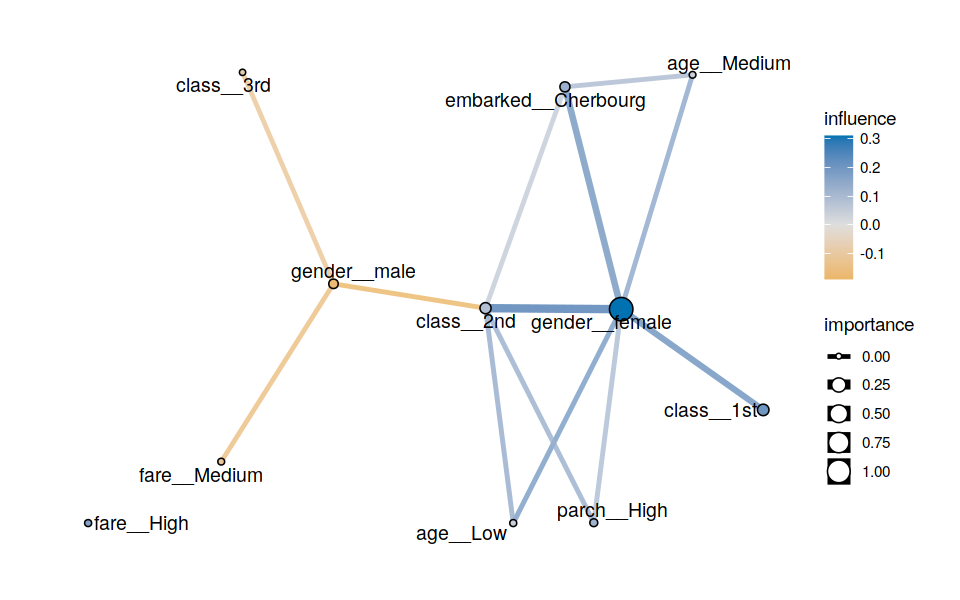

In [48]:
# from the 2nd class: men had low survival chances, women had high ones
# from the 1st class: everyone had high survival chances, though they were even higher for women
options(repr.plot.width=8, repr.plot.height=5)
plotNetwork(de_final, hide_isolated_nodes = FALSE)+
scale_edge_alpha(range = c(0.8, 1))

# Bootstrap locally

In [50]:
# same: the preCluster function is included in the function

In [51]:
rules_loc <- model2DE_resampling(model = titanic_rf, model_type = 'ranger'
                                 , data = titanic %>% select(-survived)
                                 , target = titanic$survived, classPos = 'yes'
                                 , times = 10
                                 , sample_weight = samp_weight
                                 , discretize = TRUE, K = 3
                                 , prune = TRUE, maxDecay = 0.05, typeDecay = 2 
                                 , filter = FALSE
                                 , in_parallel = TRUE, n_cores = 5
)

Extract rules...

Discretise data

Discretise rules

Initiate parallelisation ... 

Calculate metrics ... 

Pruning ... 

Generate additional decisions ... 

Initiate parallelisation ... 

Calculate metrics ... 

Pruning ... 

Generate additional decisions ... 

Initiate parallelisation ... 

Calculate metrics ... 

Pruning ... 

Generate additional decisions ... 

Initiate parallelisation ... 

Calculate metrics ... 

Pruning ... 

Generate additional decisions ... 

Initiate parallelisation ... 

Calculate metrics ... 

Pruning ... 

Generate additional decisions ... 

Initiate parallelisation ... 

Calculate metrics ... 

Pruning ... 

Generate additional decisions ... 

Initiate parallelisation ... 

Calculate metrics ... 

Pruning ... 

Generate additional decisions ... 

Initiate parallelisation ... 

Calculate metrics ... 

Pruning ... 

Generate additional decisions ... 

Initiate parallelisation ... 

Calculate metrics ... 

Pruning ... 

Generate additional decisions ... 

In

In [52]:
de_final_loc <- stabilitySelection(rules = rules_loc, alpha_error = 3)

30.6529  rules per sub-sample selected. 16 decisions in >= 7 subsets.


In [53]:
p_feat <- plotFeatures(decision_ensemble = de_final, return_all = TRUE
               , levels_order = c('male', 'female', '3rd', '2nd', '1st', 'Cherbourg','Low', 'Medium', 'High')
                      )

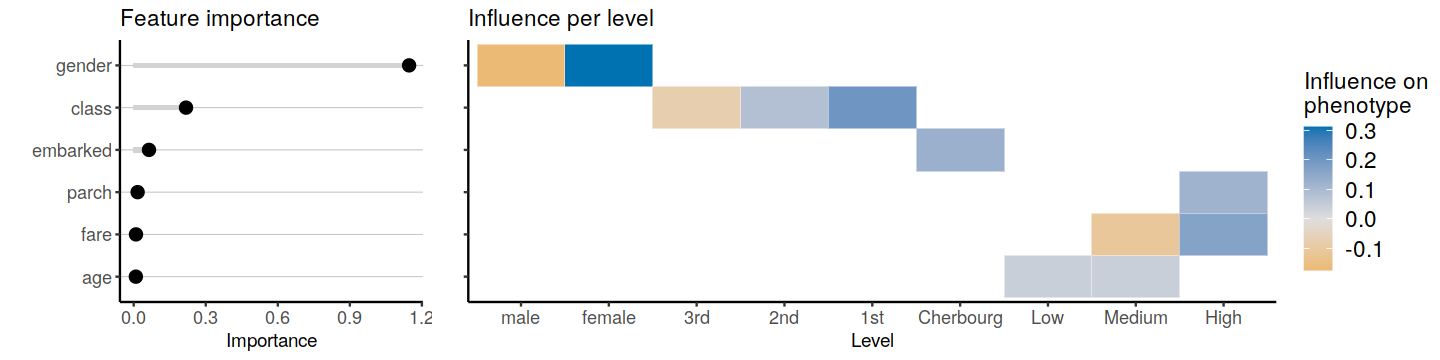

In [54]:
# we get the same plots as before
options(repr.plot.width=12, repr.plot.height=3)
ggarrange(p_feat$importance_p, p_feat$influence_p 
          , widths = c(0.3, 0.7)) # better! 

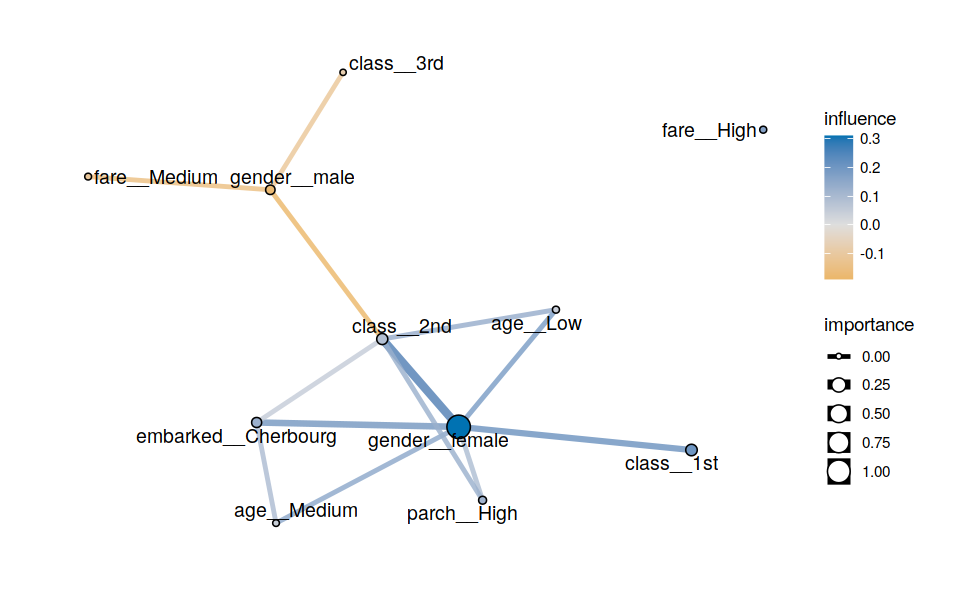

In [55]:
options(repr.plot.width=8, repr.plot.height=5)
plotNetwork(de_final, hide_isolated_nodes = FALSE, layout = 'fr')+ # I usually prefer the 'fr' layout :)
scale_edge_alpha(range = c(0.8, 1))